# Neural Networks for Solving Differential Equations

This notebook contains two main parts:

1. **ODE Solver using Neural Networks**  
2. **RC Circuit Equation Solver using Neural Networks**  

The code is adapted from the provided PDF, structured into runnable cells with explanations.


## Part 1: ODE Solver using Neural Networks

This section implements the Lagaris method to solve first-order ODEs using PyTorch.


Epoch 50
Epoch 100
Test cost =  0.016784649342298508
MSE between trial and exact solution =  0.42681729793548584


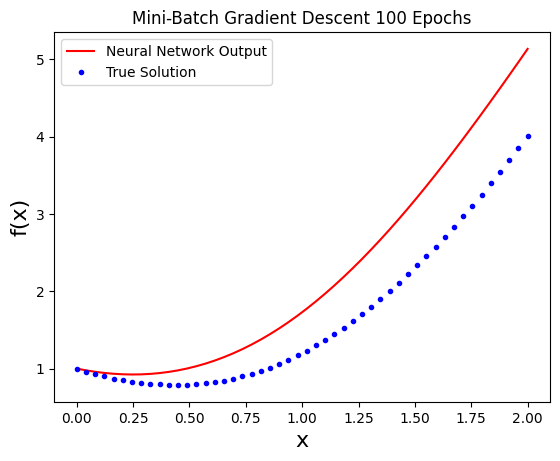

100 epochs total, final cost =  0.052660536
Total time elapsed =  2.7680413722991943  seconds


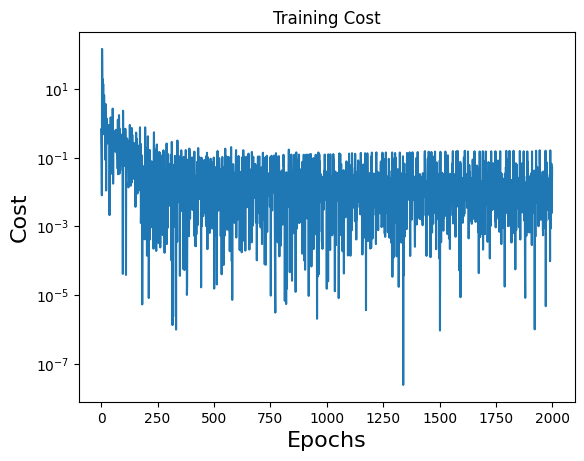

In [1]:
import torch
import torch.utils.data
import numpy as np
import matplotlib.pyplot as plt
import time
from torch.autograd import grad

# Dataset class
class DataSet(torch.utils.data.Dataset):
    def __init__(self, numSamples, xRange):
        self.dataIn = torch.linspace(xRange[0], xRange[1], numSamples, requires_grad=True).view(-1,1)
    def __len__(self):
        return len(self.dataIn)
    def __getitem__(self, idx):
        return self.dataIn[idx]

# Neural Network model
class Fitter(torch.nn.Module):
    def __init__(self, numHiddenNodes):
        super(Fitter, self).__init__()
        self.fc1 = torch.nn.Linear(in_features=1, out_features=numHiddenNodes)
        self.fc2 = torch.nn.Linear(in_features=numHiddenNodes, out_features=1)
    def forward(self, x):
        h = torch.tanh(self.fc1(x))
        y = self.fc2(h)
        return y

# Trial function for Lagaris problem 1
def trialFunc1(x, n_out):
    return 1 + x * n_out

def dTrialFunc1(x, n_out, dndx):
    return n_out + x * dndx

# Differential Equation for problem 1
def diffEq1(x, f_trial, df_trial):
    RHS = x**3 + 4*x + (x**2 * ((1+3*x**2) / (1 + x + x**3)))
    LHS = df_trial + ((x + (1+3*(x**2)) / (1 + x + x**3) ) * f_trial)
    return LHS - RHS

# Analytical solution
def solution1(x):
    return (torch.exp(-(x**2)/2) / (1 + x + x**3)) + x**2

# Plot network output
def plotNetwork(network, descentType, epoch):
    x = torch.linspace(xRange[0], xRange[1], 50, requires_grad=True).view(-1,1)
    N = network.forward(x)
    f_trial = trialFunc(x, N)
    dndx = grad(N, x, torch.ones_like(N), retain_graph=True, create_graph=True)[0]
    df_trial = dTrialFunc(x, N, dndx)
    diff_eq = diffEq(x, f_trial, df_trial)
    cost = lossFn(diff_eq, torch.zeros_like(diff_eq))
    print("Test cost = ", cost.item())
    exact = solution(x)
    MSECost = lossFn(f_trial, exact)
    print("MSE between trial and exact solution = ", MSECost.item())
    plt.plot(x.detach().numpy(), f_trial.detach().numpy(), 'r-', label="Neural Network Output")
    plt.plot(x.detach().numpy(), exact.detach().numpy(), 'b.', label="True Solution")
    plt.xlabel("x", fontsize=16)
    plt.ylabel("f(x)", fontsize=16)
    plt.legend()
    plt.title(f"{descentType} {epoch} Epochs")
    plt.show()

# Training loop
def train(network, loader, lossFn, optimiser, numEpochs):
    cost_list = []
    network.train(True)
    for epoch in range(numEpochs):
        for batch in loader:
            n_out = network.forward(batch)
            dndx = grad(n_out, batch, torch.ones_like(n_out), retain_graph=True)[0]
            f_trial = trialFunc(batch, n_out)
            df_trial = dTrialFunc(batch, n_out, dndx)
            diff_eq = diffEq(batch, f_trial, df_trial)
            cost = lossFn(diff_eq, torch.zeros_like(diff_eq))
            cost.backward()
            optimiser.step()
            optimiser.zero_grad()
            cost_list.append(cost.detach().numpy())
    network.train(False)
    return cost_list

# Parameters
xRange = [0, 2]
numSamples = 20
batchSize = 1
paramUpdates = 20000

train_set = DataSet(numSamples, xRange)
train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=batchSize, shuffle=True)

lossFn = torch.nn.MSELoss()
network = Fitter(numHiddenNodes=10)
optimiser = torch.optim.SGD(network.parameters(), lr=1e-3)

solution = solution1
trialFunc = trialFunc1
dTrialFunc = dTrialFunc1
diffEq = diffEq1

totalEpochs = 100
numEpochs = 50

costList = []
epoch = 0
start = time.time()
while epoch < totalEpochs:
    costList.extend(train(network, train_loader, lossFn, optimiser, numEpochs))
    epoch += numEpochs
    print(f"Epoch {epoch}")
end = time.time()

plotNetwork(network, "Mini-Batch Gradient Descent", epoch)
print(epoch, "epochs total, final cost = ", costList[-1])
print("Total time elapsed = ", end - start, " seconds")
plt.semilogy(costList)
plt.xlabel("Epochs", fontsize=16)
plt.ylabel("Cost", fontsize=16)
plt.title("Training Cost")
plt.show()


## Part 2: RC Circuit Equation Solver using Neural Networks

This section implements a neural network approach to solve the RC circuit's first-order ODE.


Epoch 50
Epoch 100
Test cost =  0.08396145701408386
MSE between trial and exact solution =  0.004845714196562767


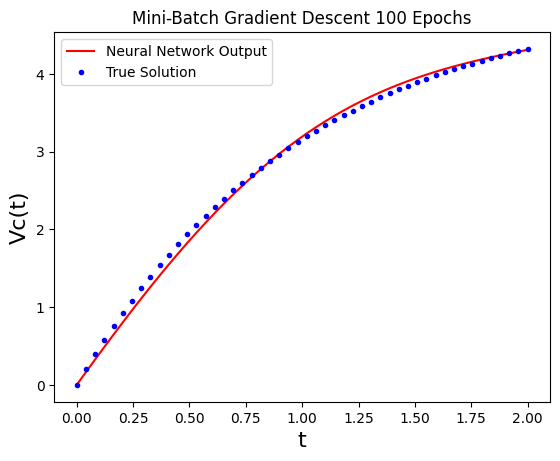

100 epochs total, final cost =  0.0119514195
Total time elapsed =  1.8544354438781738  seconds


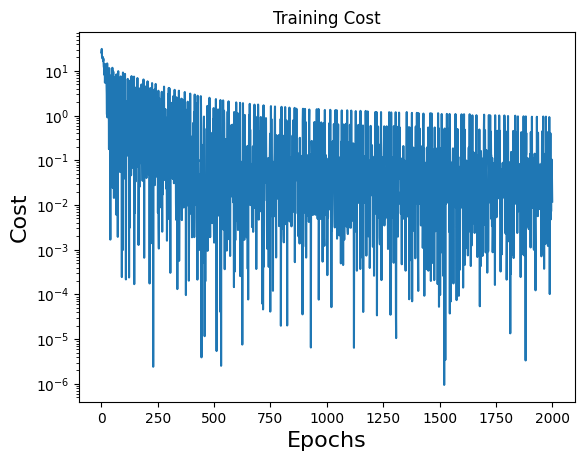

In [2]:
import torch
import torch.utils.data
import numpy as np
import matplotlib.pyplot as plt
import time
from torch.autograd import grad

# Dataset for RC circuit
class DataSet(torch.utils.data.Dataset):
    def __init__(self, numSamples, tRange):
        self.dataIn = torch.linspace(tRange[0], tRange[1], numSamples, requires_grad=True).view(-1,1)
    def __len__(self):
        return len(self.dataIn)
    def __getitem__(self, idx):
        return self.dataIn[idx]

# Network
class Fitter(torch.nn.Module):
    def __init__(self, numHiddenNodes):
        super(Fitter, self).__init__()
        self.fc1 = torch.nn.Linear(in_features=1, out_features=numHiddenNodes)
        self.fc2 = torch.nn.Linear(in_features=numHiddenNodes, out_features=1)
    def forward(self, x):
        h = torch.tanh(self.fc1(x))
        y = self.fc2(h)
        return y

# Trial and derivatives
def trialFunc_RC(t, n_out):
    return t * n_out

def dTrialFunc_RC(t, n_out, dndt):
    return n_out + t * dndt

# RC Differential equation
def diffEq_RC(t, f_trial, df_trial):
    R, C, V_in = 1, 1, 5
    LHS = df_trial + (1/(R*C)) * f_trial
    RHS = (V_in / (R*C))
    return LHS - RHS

# Analytical solution
def solution_RC(t):
    R, C, V_in = 1, 1, 5
    return V_in * (1 - torch.exp(-t/(R*C)))

# Plot function
def plotNetwork(network, descentType, epoch, solution, trialFunc):
    t = torch.linspace(tRange[0], tRange[1], 50, requires_grad=True).view(-1,1)
    N = network.forward(t)
    f_trial = trialFunc(t, N)
    dndt = grad(N, t, torch.ones_like(N), retain_graph=True, create_graph=True)[0]
    df_trial = dTrialFunc_RC(t, N, dndt)
    diff_eq = diffEq_RC(t, f_trial, df_trial)
    cost = lossFn(diff_eq, torch.zeros_like(diff_eq))
    print("Test cost = ", cost.item())
    exact = solution(t)
    MSECost = lossFn(f_trial, exact)
    print("MSE between trial and exact solution = ", MSECost.item())
    plt.plot(t.detach().numpy(), f_trial.detach().numpy(), 'r-', label="Neural Network Output")
    plt.plot(t.detach().numpy(), exact.detach().numpy(), 'b.', label="True Solution")
    plt.xlabel("t", fontsize=16)
    plt.ylabel("Vc(t)", fontsize=16)
    plt.legend()
    plt.title(f"{descentType} {epoch} Epochs")
    plt.show()

# Training
def train(network, loader, lossFn, optimiser, numEpochs):
    cost_list = []
    network.train(True)
    for epoch in range(numEpochs):
        for batch in loader:
            n_out = network.forward(batch)
            dndt = grad(n_out, batch, torch.ones_like(n_out), retain_graph=True)[0]
            f_trial = trialFunc_RC(batch, n_out)
            df_trial = dTrialFunc_RC(batch, n_out, dndt)
            diff_eq = diffEq_RC(batch, f_trial, df_trial)
            cost = lossFn(diff_eq, torch.zeros_like(diff_eq))
            cost.backward()
            optimiser.step()
            optimiser.zero_grad()
            cost_list.append(cost.detach().numpy())
    network.train(False)
    return cost_list

# Parameters
tRange = [0, 2]
numSamples = 20
batchSize = 1
paramUpdates = 20000

train_set = DataSet(numSamples, tRange)
train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=batchSize, shuffle=True)

lossFn = torch.nn.MSELoss()
network = Fitter(numHiddenNodes=10)
optimiser = torch.optim.SGD(network.parameters(), lr=1e-3)

solution = solution_RC
trialFunc = trialFunc_RC
dTrialFunc = dTrialFunc_RC
diffEq = diffEq_RC

totalEpochs = 100
numEpochs = 50

costList = []
epoch = 0
start = time.time()
while epoch < totalEpochs:
    costList.extend(train(network, train_loader, lossFn, optimiser, numEpochs))
    epoch += numEpochs
    print(f"Epoch {epoch}")
end = time.time()

plotNetwork(network, "Mini-Batch Gradient Descent", epoch, solution, trialFunc)
print(epoch, "epochs total, final cost = ", costList[-1])
print("Total time elapsed = ", end - start, " seconds")
plt.semilogy(costList)
plt.xlabel("Epochs", fontsize=16)
plt.ylabel("Cost", fontsize=16)
plt.title("Training Cost")
plt.show()
